## Test the Detection model

After training the model, let's test it with an image that the model hasn't seen before to get a sense of how good the model is.

## Run This

In [1]:
#@title Load the trained TFLite model and define some visualization functions

#@markdown This code comes from the TFLite Object Detection [Raspberry Pi sample](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

import platform
from typing import List, NamedTuple
import json

import cv2

import numpy as np
import os
from PIL import Image
import shutil
import zipfile
            
from pandas import *
from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from tflite_support import metadata

import xml.etree.ElementTree as ET
import tensorflow as tf
assert tf.__version__.startswith('2')

Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


def rename_picture_fileformat_in_annotaion(voc_dataset_dir, annotation, file_format):
    tree = ET.parse('{}/Annotations/{}.xml'.format(voc_dataset_dir,annotation))
    root = tree.getroot()
    filename_node = root.find("filename")
    filename_node.text = "{}.{}".format(annotation, file_format)
    tree.write('{}/Annotations/{}.xml'.format(voc_dataset_dir,annotation))
     
def add_pose_to_object_annotation(voc_dataset_dir,annotation):
    tree = ET.parse('{}/Annotations/{}.xml'.format(voc_dataset_dir,annotation))
    root = tree.getroot()
    object_nodes = root.findall("object")
    for object_node in object_nodes:
        ET.SubElement(object_node, 'pose').text = "Unspecified"
    tree.write('{}/Annotations/{}.xml'.format(voc_dataset_dir,annotation))
    
def convert_all_floats_to_ints(voc_dataset_dir, annotation):
    tree = ET.parse('{}/Annotations/{}.xml'.format(voc_dataset_dir,annotation))
    root = tree.getroot()
    bndbox_nodes = root.findall("./object/bndbox")
    for bndbox_node in bndbox_nodes:
        for child in bndbox_node.getchildren():
            child.text = str(int(float(child.text)))
    tree.write('{}/Annotations/{}.xml'.format(voc_dataset_dir,annotation))
    
def order_dataset(destination_dir, voc_dataset_dir):

    shutil.rmtree(destination_dir) if os.path.isdir(destination_dir) else None
    shutil.rmtree(voc_dataset_dir) if os.path.isdir(voc_dataset_dir) else None
    
    assert os.path.isfile("{}.zip".format(voc_dataset_dir)), "There is no dataset named \"{}.zip\"".format(voc_dataset_dir) 
    with zipfile.ZipFile("{}.zip".format(voc_dataset_dir),"r") as zip_dataset:
        zip_dataset.extractall(voc_dataset_dir)

    assert os.path.isdir(voc_dataset_dir), "The directory to the PVOC dataset \"{}\" doesnt exist".format(voc_dataset_dir) 

    os.makedirs(destination_dir, exist_ok=True)
    with open("{}/ImageSets/Main/default.txt".format(voc_dataset_dir)) as file:
        lines = [line.rstrip() for line in file]
        try:
            for line in lines:
                # Files might be in PNG File after exporting in CVAT but we need JPEG
                if os.path.isfile('{}/JPEGImages/{}.PNG'.format(voc_dataset_dir,line)):
                    im1 = Image.open('{}/JPEGImages/{}.PNG'.format(voc_dataset_dir, line))
                    im1.save('{}/{}.jpeg'.format(destination_dir, line))
                    rename_picture_fileformat_in_annotaion(voc_dataset_dir, line,"jpeg")
                # IF files are in JPEG just move them
                elif os.path.isfile('{}/JPEGImages/{}.jpeg'.format(voc_dataset_dir,line)):
                    os.replace('{}/JPEGImages/{}.jpeg'.format(voc_dataset_dir, line),'{}/{}.jpeg'.format(destination_dir, line))
                add_pose_to_object_annotation(voc_dataset_dir, line)
                convert_all_floats_to_ints(voc_dataset_dir,line)
                # Move the Annotation file to the destination_dir
                os.replace('{}/Annotations/{}.xml'.format(voc_dataset_dir, line),'{}/{}.xml'.format(destination_dir, line))

            # Move the labelmap file to the destination_dir
            os.replace('{}/labelmap.txt'.format(voc_dataset_dir),'{}/labelmap.txt'.format(destination_dir))
            shutil.rmtree(voc_dataset_dir)
        except:
            print("No files found in {}".format(voc_dataset_dir))

def get_labels() -> list:
    data = read_csv("res/train/labelmap.txt",sep=":",)
    labels = data['# label'].tolist()
    try:
        labels.remove('background')
    except:
        print("no background variables in labelmap.txt")
    return labels

def get_label_color(label, file="res/train/labelmap.txt") -> list:
    data = read_csv(file ,sep=":",)
    index = data.index[data['# label'] == label].to_list()[0]
    color_list = data['color_rgb'][index].replace("[","").replace("]","").split(",")
    color=()
    for rgbstring in color_list:
        color = color + (int(rgbstring),)
    return color

class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""

class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float

class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int

class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]

def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)

class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results

_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red

def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    #try:
    cv2.rectangle(image, start_point, end_point, get_label_color(detection.categories[0].label), 2)
    #except:
    #  cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 2)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)

    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    try:
      cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, get_label_color(detection.categories[0].label), _FONT_THICKNESS)
    except:
      cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)
  return image

2022-05-19 12:53:32.563128: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/cetibar/Projects/foodrecognition/venv38/lib/python3.8/site-packages/cv2/../../lib64:
2022-05-19 12:53:32.563147: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Select your Model and its threshhold

In [6]:
from os import listdir
from os.path import isfile, join
import ipywidgets as widgets
from IPython.display import display

model_path = "models"
models = [f for f in listdir(model_path) if isfile(join(model_path, f))]
model_threshhold = widgets.FloatSlider(
    value=0.5,
    min=0.1,
    max=1,
    step=0.1,
    description='Threshhold:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
model_selector = widgets.Dropdown(
    options= models,
    description='Model',
    disabled=False,
)
display(model_selector)
display(model_threshhold)

Dropdown(description='Model', options=('foodrecognition_efficientdet_lite4.tflite', 'foodrecognition_efficient…

FloatSlider(value=0.5, continuous_update=False, description='Threshhold:', max=1.0, min=0.1, readout_format='.…

## Test From Image

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/tmp/ipykernel_16190/3059572972.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image.thumbnail((512, 512), Image.ANTIALIAS)


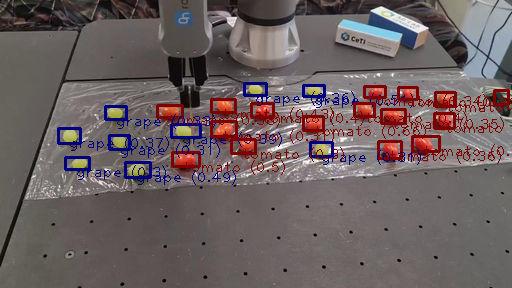

In [3]:

from PIL import Image
DETECTION_THRESHOLD = model_threshhold.value #@param {type:"number"}
TFLITE_MODEL_PATH = 'models/{}'.format(model_selector.value) #@param {type:"string"}
# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)
#try:

image = Image.open('res/train/frame_000000.jpeg').convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)
# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

#except Exception as e:
#     print(e)

# Show the detection result
Image.fromarray(image_np)

## Test from Video

In [7]:
from PIL import Image
import logging
import threading
import time
import sys 

DETECTION_THRESHOLD = model_threshhold.value #@param {type:"number"}
TFLITE_MODEL_PATH = 'models/{}'.format(model_selector.value) #@param {type:"string"}
# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=32,
      score_threshold=DETECTION_THRESHOLD,
)
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')
logger = logging.getLogger('logger')
logger.setLevel(logging.DEBUG)

detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)
#@title Run object detection and show the detection results
import cv2
# Opens the inbuilt camera of laptop to capture video.
cap = cv2.VideoCapture(0)
i = 0
stop_threads = False

detections = []

def ai_thread(stop_threads, image_dir, detector, logger:logging.Logger):

      logger.info("Thread %s: started", "ai_thread")
      logger.info("stop_threads = {}".format(stop_threads))
      global detections
      try:
            while not stop_threads:
                  logger.info("Loading Image")
                  try:
                        image = Image.open(image_dir).convert('RGB')
                        image_np = np.asarray(image)
                        detections = detector.detect(image_np)
                  except Exception as exception:
                        logger.error(exception)
                  logger.info("detections {}".format(detections))
      except Exception as exception:
            logger.error(exception)

logger.info("Thread %s: starting", "ai_thread")
ai_threading = threading.Thread(target=ai_thread, args=( stop_threads,"res/frame/frame.jpg", detector, logger), name="ai_threading")
ai_threading.start()
while(cap.isOpened()):
      try:
            ret, frame = cap.read()
            # This condition prevents from infinite looping
            # incase video ends.
            if ret == False:
                  break
            # Save Frame by Frame into disk using imwrite method
            cv2.imwrite('res/frame/frame.jpg',frame)
            image_np = np.asarray(frame)

            # Draw keypoints and edges on input image
            image_np = visualize(image_np, detections)

            # Display the resulting frame
            cv2.imshow('frame', image_np)
      
            # the 'q' button is set as the
            # quitting button you may use any
            # desired button of your choice
            if cv2.waitKey(1) & 0xFF == ord('q'):
                  break 
      except: 
            stop_threads = True      
cap.release()
stop_threads = True  
cv2.destroyAllWindows()


2022-05-19 13:20:31,671 | INFO : Hello world!
2022-05-19 13:20:31,956 | INFO : Thread ai_thread: starting
2022-05-19 13:20:31,969 | INFO : Thread ai_thread: started
2022-05-19 13:20:31,970 | INFO : stop_threads = False
2022-05-19 13:20:31,970 | INFO : Loading Image
2022-05-19 13:20:32,601 | INFO : detections []
2022-05-19 13:20:32,615 | INFO : Loading Image
2022-05-19 13:20:33,261 | INFO : detections []
2022-05-19 13:20:33,261 | INFO : Loading Image
2022-05-19 13:20:33,715 | INFO : detections []
2022-05-19 13:20:33,715 | INFO : Loading Image
2022-05-19 13:20:34,357 | INFO : detections []
2022-05-19 13:20:34,360 | INFO : Loading Image
2022-05-19 13:20:34,361 | ERROR : image file is truncated (95 bytes not processed)
2022-05-19 13:20:34,362 | INFO : detections []
2022-05-19 13:20:34,362 | INFO : Loading Image
2022-05-19 13:20:34,364 | ERROR : image file is truncated (75 bytes not processed)
2022-05-19 13:20:34,364 | INFO : detections []
2022-05-19 13:20:34,365 | INFO : Loading Image
2022